# 🫁 Pneumonia Detection from Chest X-Ray Images
### ResNet50 Transfer Learning — Final Version

**Dataset**: PneumoniaMNIST (~5,800 images, 28×28 grayscale) from MedMNIST v2  
**Task**: Binary Classification — Normal vs Pneumonia  
**Models**: Baseline CNN + ResNet50 (Primary Focus)



## 📦Imports & GPU Setup

In [1]:
%matplotlib inline
from IPython.display import display, clear_output

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

!pip install medmnist -q
import medmnist
from medmnist import INFO

from tensorflow.keras import layers, models, applications
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)

# GPU setup
print(f"TensorFlow : {tf.__version__}")
print(f"GPUs found : {tf.config.list_physical_devices('GPU')}")
try:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print(f"GPU config note: {e}")

# Matplotlib style
plt.rcParams.update({
    'figure.dpi': 100,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})
print("\n✅ Setup complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.1 MB/s eta 0:00:00
TensorFlow : 2.19.0
GPUs found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Setup complete.


## ⚙️ Configuration

In [2]:
class Config:
    # Dataset
    DATASET_NAME  = "pneumoniamnist"
    IMG_SIZE      = (224, 224)
    CHANNELS      = 3
    CLASS_NAMES   = ["NORMAL", "PNEUMONIA"]
    SEED          = 42

    # Training
    BATCH_SIZE    = 32
    INITIAL_LR    = 3e-4        # Baseline CNN
    EPOCHS        = 40          # Baseline CNN max epochs
    PATIENCE      = 10          # Baseline CNN early stop patience

    # ResNet50 — Phase 1 (head only)
    RN_HEAD_LR    = 1e-4        # Lower LR — pre-trained weights
    RN_HEAD_EPOCHS = 15
    RN_HEAD_PATIENCE = 8

    # ResNet50 — Phase 2 (fine-tune)
    RN_FT_LR      = 1e-5        # Very low — prevent catastrophic forgetting
    RN_FT_EPOCHS  = 20
    RN_FT_PATIENCE = 5          # FIXED: was 10 — val plateaus early
    RN_FT_MIN_DELTA = 0.001     # FIXED: stop if < 0.1% improvement
    RN_UNFREEZE_LAYERS = 10     # FIXED: was 20 — too many for small dataset

    OUTPUT_DIR    = "outputs"

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)
print("✅ Config loaded.")
print(f"   ResNet50 Phase2: unfreeze last {Config.RN_UNFREEZE_LAYERS} layers, patience={Config.RN_FT_PATIENCE}, min_delta={Config.RN_FT_MIN_DELTA}")

✅ Config loaded.
   ResNet50 Phase2: unfreeze last 10 layers, patience=5, min_delta=0.001


## 📊  Data Loading & Augmentation

In [3]:
def get_data_augmentation():
    """Light, medically-safe augmentation for training only."""
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", seed=Config.SEED),
        tf.keras.layers.RandomRotation(0.1, seed=Config.SEED),
        tf.keras.layers.RandomZoom(0.1, seed=Config.SEED),
        tf.keras.layers.RandomContrast(0.1, seed=Config.SEED),
        tf.keras.layers.RandomTranslation(0.05, 0.05, seed=Config.SEED),
    ], name="augmentation")


def preprocess_image(image, label):
    """Convert grayscale→RGB, resize, normalize to [0,1]."""
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, Config.IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


def get_medmnist_dataset(split, shuffle=True, augment=False):
    """Load a PneumoniaMNIST split as a tf.data pipeline."""
    info = INFO[Config.DATASET_NAME]
    DataClass = getattr(medmnist, info['python_class'])
    dataset   = DataClass(split=split, download=True)

    images = np.expand_dims(dataset.imgs, axis=-1)   # (N,28,28,1)
    labels = dataset.labels

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    AUTOTUNE = tf.data.AUTOTUNE

    if shuffle:
        ds = ds.shuffle(len(images), seed=Config.SEED, reshuffle_each_iteration=True)

    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = get_data_augmentation()
        ds  = ds.map(lambda x, y: (aug(x, training=True), y),
                     num_parallel_calls=AUTOTUNE)

    return ds.batch(Config.BATCH_SIZE).prefetch(AUTOTUNE)


print("Loading datasets...")
train_ds = get_medmnist_dataset('train', shuffle=True,  augment=True)
val_ds   = get_medmnist_dataset('val',   shuffle=False, augment=False)
test_ds  = get_medmnist_dataset('test',  shuffle=False, augment=False)

print(f"  Train batches : {len(list(train_ds))}")
print(f"  Val   batches : {len(list(val_ds))}")
print(f"  Test  batches : {len(list(test_ds))}")
print("✅ Datasets ready.")

Loading datasets...


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.35MB/s]


  Train batches : 148
  Val   batches : 17
  Test  batches : 20
✅ Datasets ready.


## 🔍 Dataset Visualization

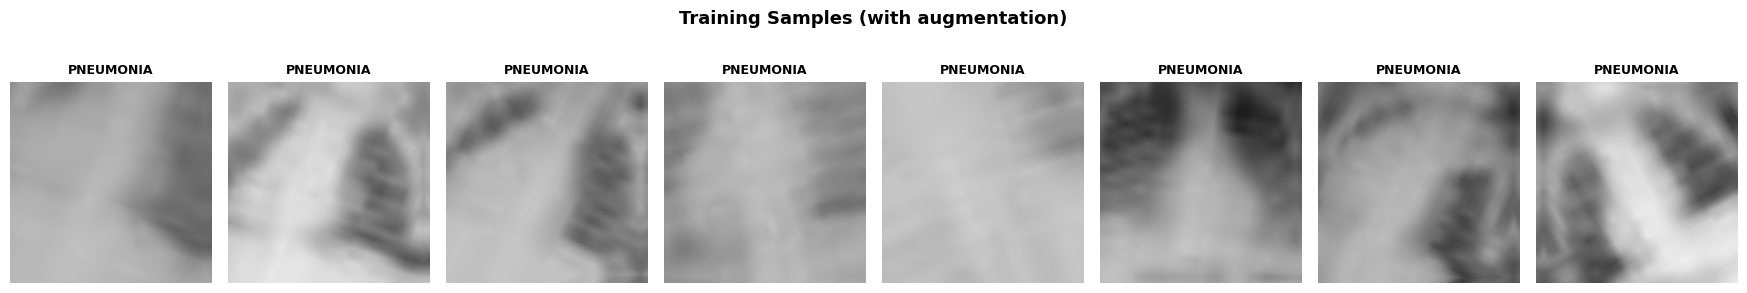


Class distribution (train):
  NORMAL: 1214  PNEUMONIA: 3494
  Weights → NORMAL: 1.939  PNEUMONIA: 0.674
✅ Class weights computed.


In [4]:
def visualize_samples(dataset, n=8, title="Samples"):
    fig, axes = plt.subplots(1, n, figsize=(2.2 * n, 3))
    count = 0
    for images, labels in dataset:
        for i in range(len(images)):
            if count >= n: break
            axes[count].imshow(np.clip(images[i].numpy(), 0, 1))
            axes[count].set_title(Config.CLASS_NAMES[int(labels[i])],
                                  fontsize=9, fontweight='bold')
            axes[count].axis('off')
            count += 1
        if count >= n: break
    fig.suptitle(title, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_samples(train_ds, title="Training Samples (with augmentation)")


def get_class_weights(ds):
    """Compute inverse-frequency class weights."""
    labels = np.concatenate([y.numpy().flatten() for _, y in ds])
    n0, n1 = np.sum(labels == 0), np.sum(labels == 1)
    total  = len(labels)
    w = {0: total / (2 * n0), 1: total / (2 * n1)}
    print(f"  NORMAL: {n0}  PNEUMONIA: {n1}")
    print(f"  Weights → NORMAL: {w[0]:.3f}  PNEUMONIA: {w[1]:.3f}")
    return w

print("\nClass distribution (train):")
class_weights = get_class_weights(train_ds)
print("✅ Class weights computed.")

## 🧠  Model Architectures
### 5A — Baseline CNN

In [5]:
def build_baseline_cnn():
    """
    Regularized CNN:
    - L2(1e-4) on all conv + dense layers
    - SpatialDropout2D after each conv block
    - Small dense head (64 units) + Dropout(0.6)
    """
    r = tf.keras.regularizers.l2(1e-4)

    return models.Sequential([
        layers.Input(shape=(*Config.IMG_SIZE, Config.CHANNELS)),

        # Block 1
        layers.Conv2D(32, 3, padding='same', kernel_regularizer=r),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2), layers.SpatialDropout2D(0.10, seed=Config.SEED),

        # Block 2
        layers.Conv2D(64, 3, padding='same', kernel_regularizer=r),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2), layers.SpatialDropout2D(0.15, seed=Config.SEED),

        # Block 3
        layers.Conv2D(128, 3, padding='same', kernel_regularizer=r),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2), layers.SpatialDropout2D(0.20, seed=Config.SEED),

        # Block 4
        layers.Conv2D(128, 3, padding='same', kernel_regularizer=r),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, kernel_regularizer=r),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.Dropout(0.6, seed=Config.SEED),
        layers.Dense(1, activation='sigmoid')
    ], name="baseline_cnn")

print("Baseline CNN architecture:")
build_baseline_cnn().summary()

Baseline CNN architecture:


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,25

 Total params: 250,817 (979.75 KB)

 Trainable params: 249,985 (976.50 KB)

 Non-trainable params: 832 (3.25 KB)

### 5B — ResNet50 (Primary Model)

In [6]:
def build_resnet50():
    """
    ResNet50 Transfer Learning — Fixed Architecture:

    KEY FIXES vs original:
    1. Rescaling layer  : [0,1]→[0,255] before ResNet preprocessing
    2. training=False   : backbone BN uses stored stats (not batch stats)
    3. Single-layer head: 256 units only (was 512+256 — memorized)
    4. L2(1e-4)         : on head dense layer
    5. Dropout(0.5)     : prevents head overfitting
    """
    r = tf.keras.regularizers.l2(1e-4)

    inputs = layers.Input(shape=(*Config.IMG_SIZE, Config.CHANNELS))

    # Step 1: Scale [0,1] → [0,255] then apply ImageNet normalization
    x = layers.Rescaling(255.0)(inputs)
    x = layers.Lambda(
        lambda i: applications.resnet50.preprocess_input(i),
        name="imagenet_preprocess"
    )(x)

    # Step 2: ResNet50 backbone (frozen initially)
    backbone = applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(*Config.IMG_SIZE, Config.CHANNELS)
    )
    backbone.trainable = False
    x = backbone(x, training=False)   # BN uses running mean/var

    # Step 3: Classification head
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(256, kernel_regularizer=r, name="head_dense")(x)
    x = layers.BatchNormalization(name="head_bn")(x)
    x = layers.Activation('relu', name="head_relu")(x)
    x = layers.Dropout(0.5, seed=Config.SEED, name="head_dropout")(x)
    outputs = layers.Dense(1, activation='sigmoid', name="output")(x)

    model = models.Model(inputs, outputs, name="resnet50_fixed")
    return model, backbone

print("ResNet50 architecture:")
rn_model, _ = build_resnet50()
rn_model.summary()
del rn_model   # will rebuild during training

ResNet50 architecture:
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50_fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ imagenet_preprocess (Lambda)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense (Dense)              │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_bn (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_relu (Activation)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

## 📈  Live Training Graph Callback
> Graphs update **inside the notebook** after every epoch — no need to open external files.

In [7]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    """
    Renders a live Loss / Accuracy / AUC chart directly in the
    notebook cell after every epoch using clear_output().
    """
    COLORS = {
        'train': ['#1565C0', '#2E7D32', '#6A1B9A'],
        'val'  : ['#EF6C00', '#C62828', '#AD1457'],
    }
    METRICS = ['loss', 'accuracy', 'auc']

    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.hist = {m: [] for m in self.METRICS + [f'val_{m}' for m in self.METRICS]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.hist:
            if k in logs:
                self.hist[k].append(float(logs[k]))

        if not self.hist['loss']:
            return

        clear_output(wait=True)
        epochs_x = range(1, len(self.hist['loss']) + 1)

        fig, axes = plt.subplots(1, 3, figsize=(17, 4.5))
        labels = ['Loss', 'Accuracy', 'AUC']

        for idx, (ax, metric, label) in enumerate(
                zip(axes, self.METRICS, labels)):
            tc = self.COLORS['train'][idx]
            vc = self.COLORS['val'][idx]

            tr_vals  = self.hist[metric]
            val_vals = self.hist[f'val_{metric}']

            ax.plot(epochs_x, tr_vals,  color=tc, lw=2.2,
                    label='Train', marker='o', markersize=4)
            if val_vals:
                ax.plot(epochs_x, val_vals, color=vc, lw=2.2,
                        label='Validation', marker='s', markersize=4,
                        linestyle='--')
                ax.fill_between(epochs_x, tr_vals, val_vals,
                                alpha=0.07, color='grey')

            # Annotate final values
            ax.annotate(f"{tr_vals[-1]:.4f}",
                        xy=(epochs_x[-1], tr_vals[-1]),
                        xytext=(6, 4), textcoords='offset points',
                        fontsize=8.5, color=tc, fontweight='bold')
            if val_vals:
                ax.annotate(f"{val_vals[-1]:.4f}",
                            xy=(epochs_x[-1], val_vals[-1]),
                            xytext=(6, -14), textcoords='offset points',
                            fontsize=8.5, color=vc, fontweight='bold')

            ax.set_title(f"{label}", fontsize=13, fontweight='bold')
            ax.set_xlabel('Epoch', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.legend(fontsize=9, loc='best')
            ax.grid(True, alpha=0.25)

        best_auc = max(self.hist['val_auc']) if self.hist['val_auc'] else 0
        fig.suptitle(
            f"🔄  {self.model_name}  |  Epoch {epoch+1}  |  "
            f"Train Loss: {logs.get('loss',0):.4f}   "
            f"Val Loss: {logs.get('val_loss',0):.4f}   "
            f"Val AUC: {logs.get('val_auc',0):.4f}   "
            f"Best Val AUC: {best_auc:.4f}",
            fontsize=11, fontweight='bold', y=1.03
        )
        plt.tight_layout()
        plt.show()


def plot_final_history(history, model_name, phase=None):
    """
    Static final plot saved to disk + displayed inline.
    Called once after training finishes.
    """
    h = history.history
    metrics = [m for m in ['loss', 'accuracy', 'auc'] if m in h]
    colors_tr  = ['#1565C0', '#2E7D32', '#6A1B9A']
    colors_val = ['#EF6C00', '#C62828', '#AD1457']

    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5))
    if len(metrics) == 1: axes = [axes]

    for ax, metric, tc, vc in zip(axes, metrics, colors_tr, colors_val):
        ep = range(1, len(h[metric]) + 1)
        ax.plot(ep, h[metric],           color=tc, lw=2.2, label='Train',
                marker='o', markersize=4)
        ax.plot(ep, h[f'val_{metric}'],  color=vc, lw=2.2, label='Validation',
                marker='s', markersize=4, linestyle='--')
        ax.fill_between(ep, h[metric], h[f'val_{metric}'],
                        alpha=0.07, color='grey')
        ax.set_title(metric.capitalize(), fontsize=13, fontweight='bold')
        ax.set_xlabel('Epoch'); ax.set_ylabel(metric.capitalize())
        ax.legend(); ax.grid(True, alpha=0.25)

    best_auc = max(h.get('val_auc', [0]))
    best_acc = max(h.get('val_accuracy', [0]))
    title_tag = f" [{phase}]" if phase else ""
    fig.suptitle(
        f"{model_name}{title_tag}  |  "
        f"Best Val AUC: {best_auc:.4f}   Best Val Acc: {best_acc:.4f}",
        fontsize=12, fontweight='bold', y=1.02
    )
    plt.tight_layout()
    name = f"{model_name}_{phase}" if phase else model_name
    path = os.path.join(Config.OUTPUT_DIR, f"{name}_history.png")
    plt.savefig(path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✅ Best Val AUC : {best_auc:.4f}")
    print(f"  ✅ Best Val Acc : {best_acc:.4f}")
    print(f"  💾 Saved        : {path}")


print("✅ LivePlotCallback & plot_final_history defined.")

✅ LivePlotCallback & plot_final_history defined.


## 🔧 Callback Factory

In [8]:
def get_callbacks(model_name, monitor='val_auc',
                  patience=10, min_delta=0.0):
    """
    Returns [LivePlotCallback, ModelCheckpoint,
             EarlyStopping, ReduceLROnPlateau, CSVLogger]
    """
    ckpt = os.path.join(Config.OUTPUT_DIR, f"{model_name}_best.keras")
    return [
        LivePlotCallback(model_name),
        tf.keras.callbacks.ModelCheckpoint(
            ckpt, monitor=monitor, save_best_only=True,
            mode='max', verbose=0),
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=patience,
            min_delta=min_delta,          # FIXED: stops if improvement < min_delta
            restore_best_weights=True,
            mode='max', verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5,
            patience=3, min_lr=1e-8, verbose=1),
        tf.keras.callbacks.CSVLogger(
            os.path.join(Config.OUTPUT_DIR, f"{model_name}_log.csv"),
            append=False),
    ]

print("✅ Callback factory ready.")

✅ Callback factory ready.


##  Train Baseline CNN

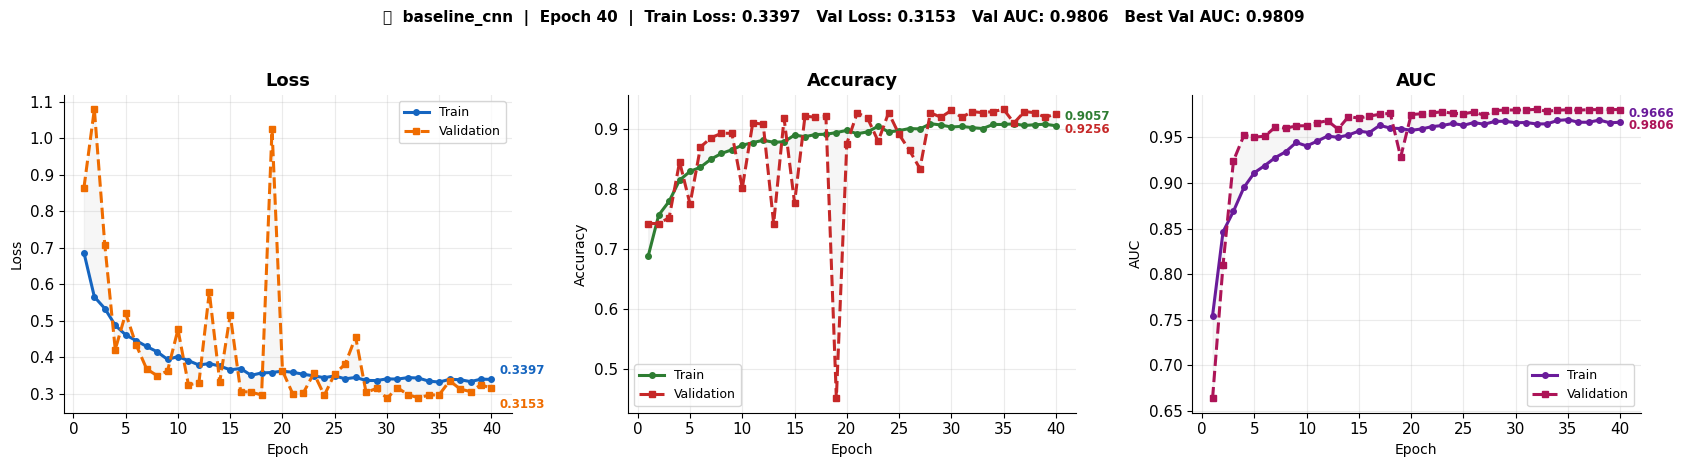

148/148 ━━━━━━━━━━━━━━━━━━━━ 73s 488ms/step - accuracy: 0.9097 - auc: 0.9671 - loss: 0.3402 - precision: 0.9713 - recall: 0.9039 - val_accuracy: 0.9256 - val_auc: 0.9806 - val_loss: 0.3153 - val_precision: 0.9730 - val_recall: 0.9254 - learning_rate: 4.6875e-06
Restoring model weights from the end of the best epoch: 32.

📊 Final training summary:


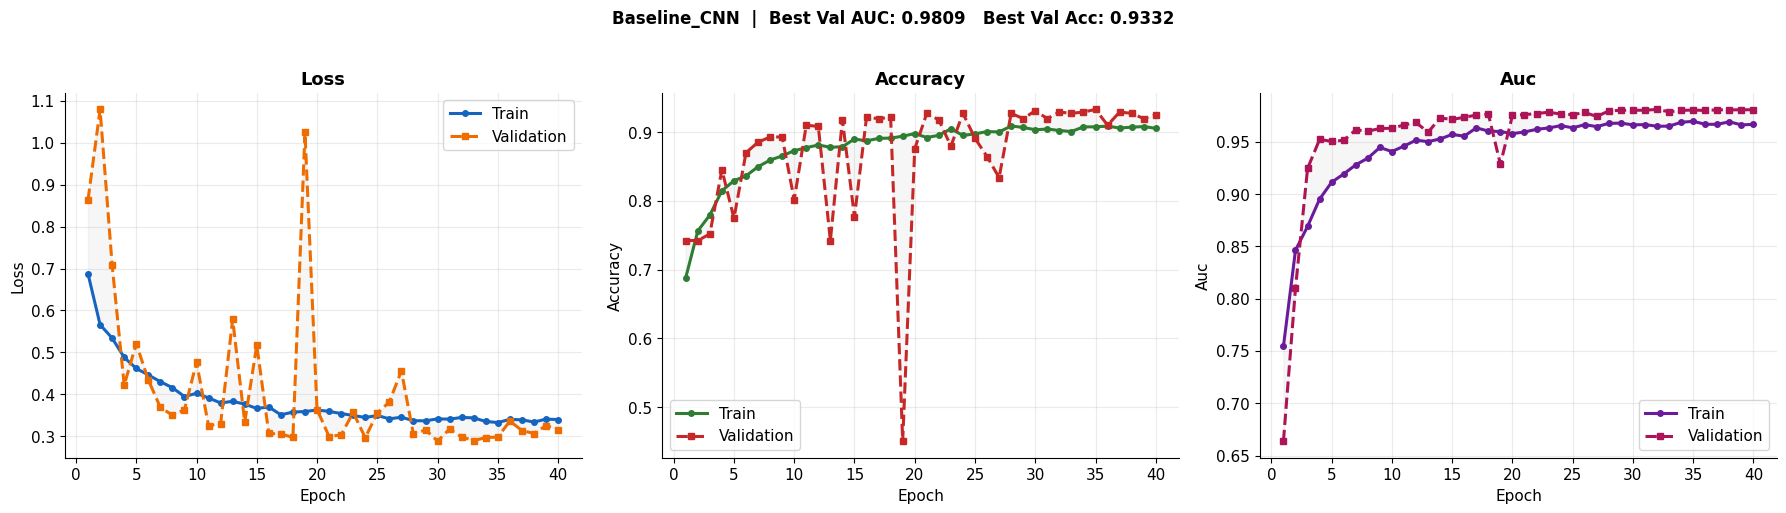


  ✅ Best Val AUC : 0.9809
  ✅ Best Val Acc : 0.9332
  💾 Saved        : outputs/Baseline_CNN_history.png


In [9]:
TRAIN_BASELINE = True

if TRAIN_BASELINE:
    print("="*55)
    print(" Training Baseline CNN")
    print("="*55)

    baseline_model = build_baseline_cnn()
    baseline_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=Config.INITIAL_LR, clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

    baseline_history = baseline_model.fit(
        train_ds, validation_data=val_ds,
        epochs=Config.EPOCHS,
        class_weight=class_weights,
        callbacks=get_callbacks(
            'baseline_cnn',
            patience=Config.PATIENCE,
            min_delta=0.001)
    )

    print("\n📊 Final training summary:")
    plot_final_history(baseline_history, 'Baseline_CNN')
else:
    print("TRAIN_BASELINE=False — skipping.")

## Train ResNet50 (Phase 1: Head Only)
> Backbone frozen — only the 256-unit classification head is trained.

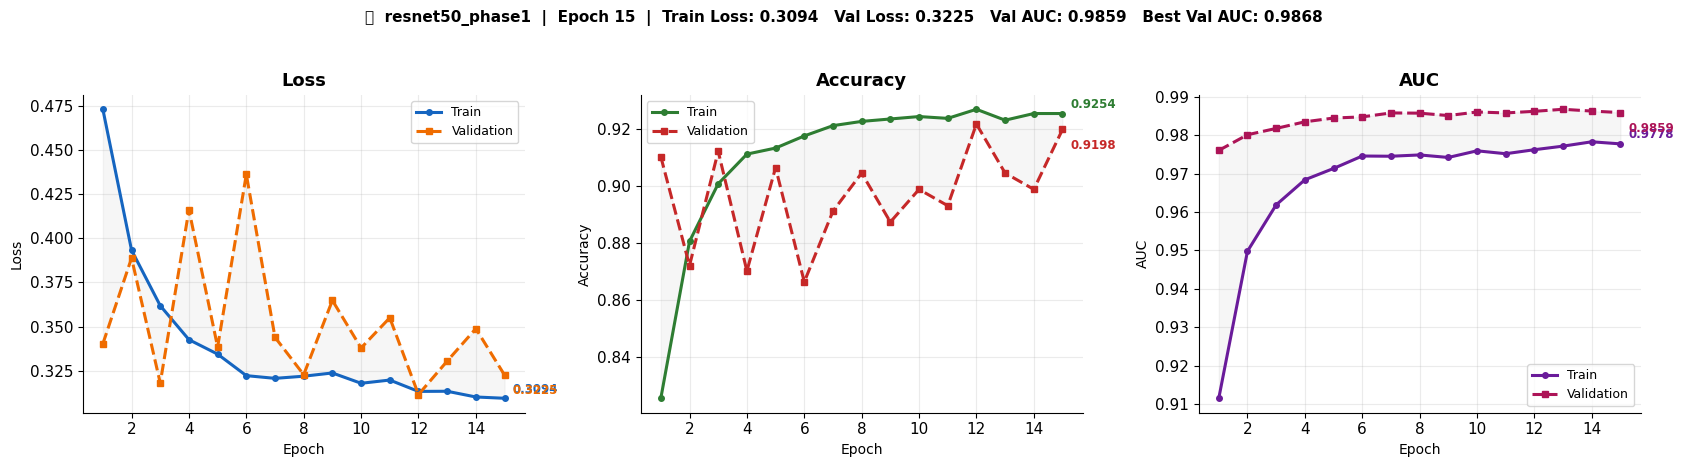


Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
148/148 ━━━━━━━━━━━━━━━━━━━━ 74s 499ms/step - accuracy: 0.9253 - auc: 0.9778 - loss: 0.3109 - precision: 0.9739 - recall: 0.9241 - val_accuracy: 0.9198 - val_auc: 0.9859 - val_loss: 0.3225 - val_precision: 0.9887 - val_recall: 0.9023 - learning_rate: 2.5000e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 7.

✅ Loaded best Phase-1 weights.

📊 Phase 1 training summary:


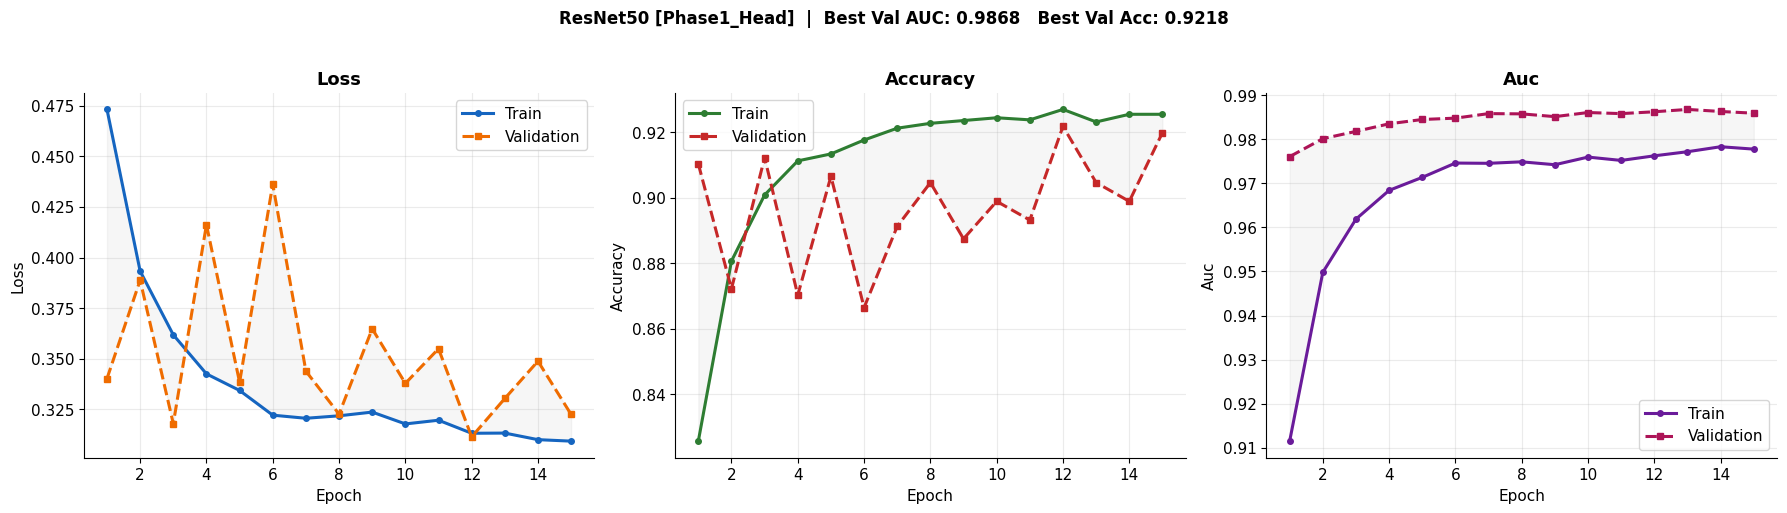


  ✅ Best Val AUC : 0.9868
  ✅ Best Val Acc : 0.9218
  💾 Saved        : outputs/ResNet50_Phase1_Head_history.png


In [10]:
TRAIN_ADVANCED = True

if TRAIN_ADVANCED:
    print("="*55)
    print(" ResNet50 — Phase 1: Head Training (backbone frozen)")
    print("="*55)

    resnet_model, backbone = build_resnet50()

    # Backbone is already frozen inside build_resnet50()
    resnet_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=Config.RN_HEAD_LR,  # 1e-4
            clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

    phase1_history = resnet_model.fit(
        train_ds, validation_data=val_ds,
        epochs=Config.RN_HEAD_EPOCHS,
        class_weight=class_weights,
        callbacks=get_callbacks(
            'resnet50_phase1',
            patience=Config.RN_HEAD_PATIENCE,
            min_delta=0.001)
    )

    # Restore best phase-1 weights
    p1_ckpt = os.path.join(Config.OUTPUT_DIR, 'resnet50_phase1_best.keras')
    if os.path.exists(p1_ckpt):
        resnet_model.load_weights(p1_ckpt)
        print("\n✅ Loaded best Phase-1 weights.")

    print("\n📊 Phase 1 training summary:")
    plot_final_history(phase1_history, 'ResNet50', phase='Phase1_Head')

else:
    print("TRAIN_ADVANCED=False — skipping.")

##   Train ResNet50 (Phase 2: Fine-Tune)
> **Key fixes**: unfreeze only last 10 layers, BN stays frozen, `weight_decay`, tighter early stopping.

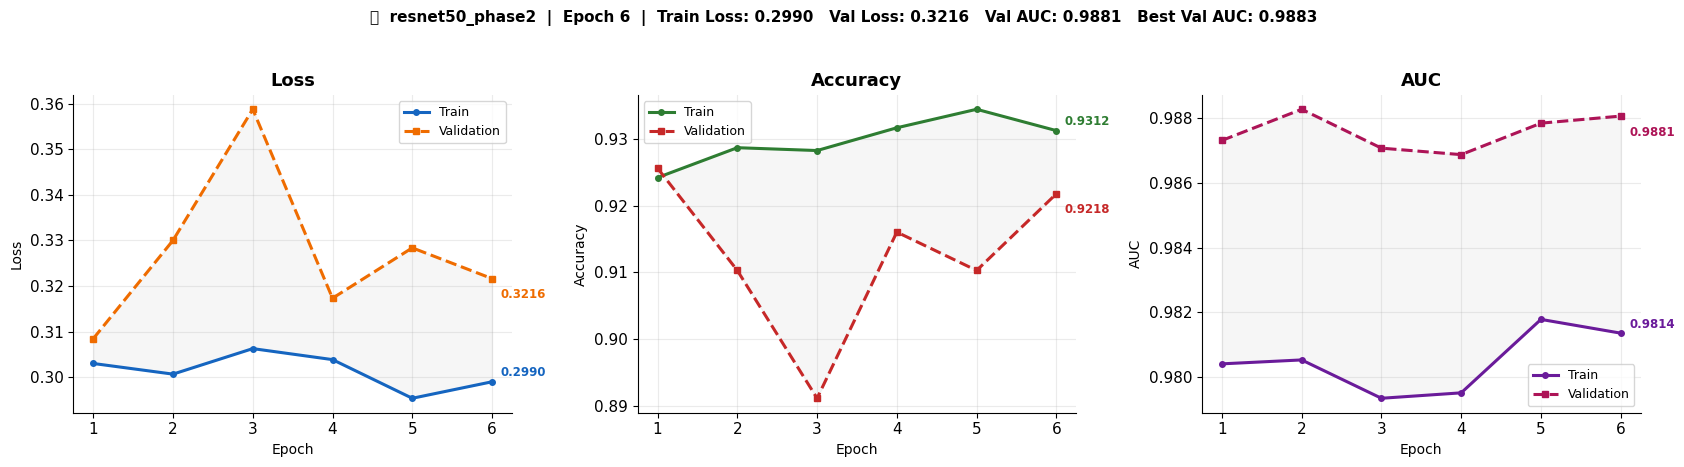

148/148 ━━━━━━━━━━━━━━━━━━━━ 77s 512ms/step - accuracy: 0.9353 - auc: 0.9828 - loss: 0.2921 - precision: 0.9765 - recall: 0.9359 - val_accuracy: 0.9218 - val_auc: 0.9881 - val_loss: 0.3216 - val_precision: 0.9888 - val_recall: 0.9049 - learning_rate: 5.0000e-06
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

✅ Loaded best Phase-2 weights.

📊 Phase 2 training summary:


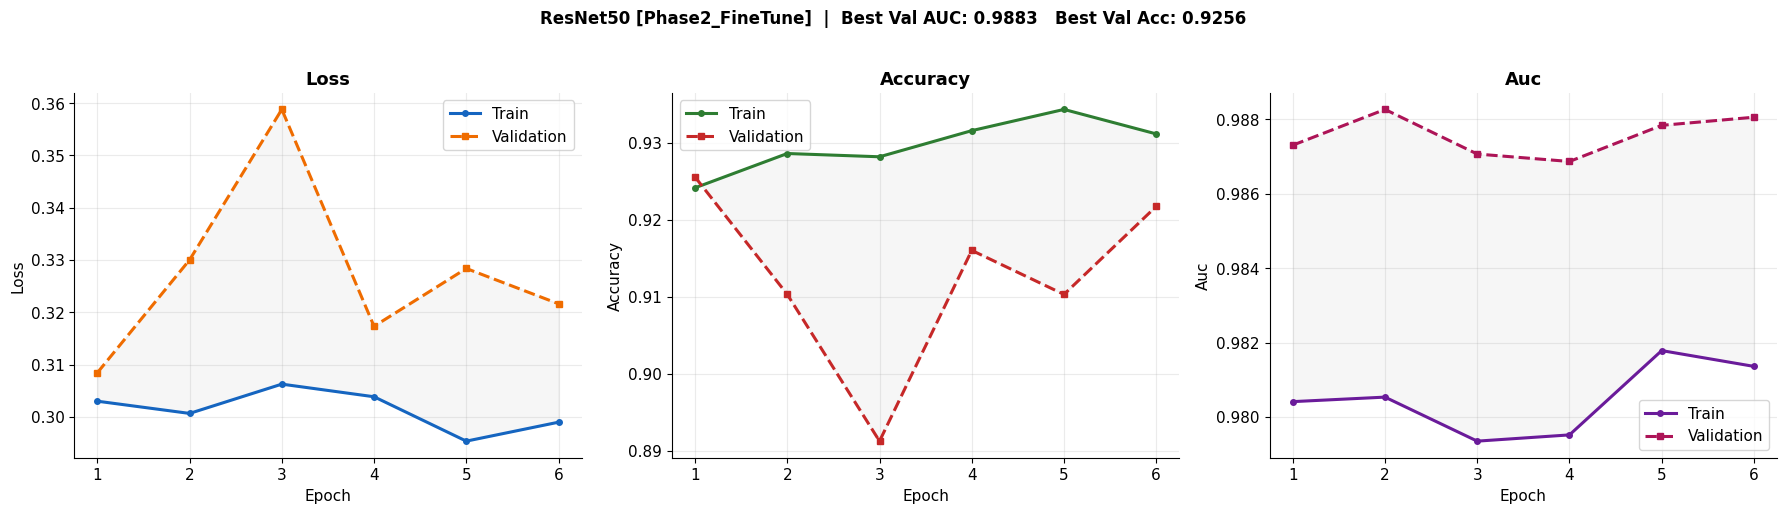


  ✅ Best Val AUC : 0.9883
  ✅ Best Val Acc : 0.9256
  💾 Saved        : outputs/ResNet50_Phase2_FineTune_history.png


In [11]:
if TRAIN_ADVANCED:
    print("="*55)
    print(f" ResNet50 — Phase 2: Fine-Tune (last {Config.RN_UNFREEZE_LAYERS} layers)")
    print("="*55)

    # ── FIXED: Unfreeze only last 10 layers (was 20) ──────────────
    backbone.trainable = True
    for layer in backbone.layers[:-Config.RN_UNFREEZE_LAYERS]:
        layer.trainable = False

    # ── FIXED: Keep ALL BatchNorm layers frozen ────────────────────
    for layer in backbone.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    trainable_count = sum(1 for l in backbone.layers if l.trainable)
    print(f"Unfrozen backbone layers: {trainable_count}")

    resnet_model.compile(
        # FIXED: weight_decay prevents large updates to backbone weights
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=Config.RN_FT_LR,   # 1e-5
            clipnorm=1.0,
            weight_decay=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

    phase2_history = resnet_model.fit(
        train_ds, validation_data=val_ds,
        epochs=Config.RN_FT_EPOCHS,
        class_weight=class_weights,
        # FIXED: patience=5, min_delta=0.001 — stops when val plateaus
        callbacks=get_callbacks(
            'resnet50_phase2',
            patience=Config.RN_FT_PATIENCE,
            min_delta=Config.RN_FT_MIN_DELTA)
    )

    # Restore best phase-2 weights
    p2_ckpt = os.path.join(Config.OUTPUT_DIR, 'resnet50_phase2_best.keras')
    if os.path.exists(p2_ckpt):
        resnet_model.load_weights(p2_ckpt)
        print("\n✅ Loaded best Phase-2 weights.")

    print("\n📊 Phase 2 training summary:")
    plot_final_history(phase2_history, 'ResNet50', phase='Phase2_FineTune')

else:
    print("TRAIN_ADVANCED=False — skipping.")

## 📉  Evaluation Functions

In [12]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7, 5.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES,
                annot_kws={'size': 18, 'weight': 'bold'})
    ax.set_title(f'Confusion Matrix — {model_name}',
                 fontsize=14, fontweight='bold', pad=14)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual',    fontsize=12)

    tn, fp, fn, tp = cm.ravel()
    ax.set_xlabel(
        f"Predicted   |   TN={tn}  FP={fp}  FN={fn}  TP={tp}  "
        f"Sensitivity={tp/(tp+fn):.3f}  Specificity={tn/(tn+fp):.3f}",
        fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, f"{model_name}_cm.png"),
                dpi=150, bbox_inches='tight')
    plt.show()


def plot_roc(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc     = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(7, 5.5))
    ax.plot(fpr, tpr, color='#EF6C00', lw=2.5,
            label=f'AUC = {roc_auc:.4f}')
    ax.plot([0,1],[0,1], color='#455A64', lw=1.5,
            linestyle='--', label='Random')
    ax.fill_between(fpr, tpr, alpha=0.10, color='#EF6C00')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate',  fontsize=12)
    ax.set_title(f'ROC Curve — {model_name}',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11); ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, f"{model_name}_roc.png"),
                dpi=150, bbox_inches='tight')
    plt.show()


def plot_failure_cases(images, true_labels, probs, model_name, case_type, n=12):
    n_show = min(n, len(images))
    cols   = 4
    rows   = (n_show + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 3.5))
    axes = axes.flatten()

    color = '#C62828' if case_type == 'False_Negative' else '#1565C0'
    for i in range(n_show):
        axes[i].imshow(np.clip(images[i], 0, 1), cmap='gray')
        t = Config.CLASS_NAMES[int(true_labels[i])]
        p = Config.CLASS_NAMES[int(probs[i] > 0.5)]
        axes[i].set_title(
            f"True: {t}\nPred: {p}\nProb: {probs[i]:.3f}",
            fontsize=8, color=color)
        axes[i].axis('off')
    for j in range(n_show, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{model_name} — {case_type.replace('_',' ')} ({n_show} cases)",
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR,
                             f"{model_name}_{case_type}.png"),
                dpi=150, bbox_inches='tight')
    plt.show()


def predict_tta(model, images):
    """Test-time augmentation: average original + horizontal flip."""
    p1 = model.predict(images, verbose=0)
    p2 = model.predict(tf.image.flip_left_right(images), verbose=0)
    return np.mean([p1, p2], axis=0)


def evaluate_model(model, model_name, val_ds, test_ds, use_tta=True):
    """Full evaluation: metrics, threshold tuning, plots, failure cases."""
    print(f"\n{'='*55}")
    print(f"  Evaluating: {model_name}")
    print(f"{'='*55}")

    # ── Threshold tuning on validation set ─────────────────────────
    y_tv, y_pv = [], []
    for imgs, labs in val_ds:
        preds = predict_tta(model, imgs) if use_tta else model.predict(imgs, verbose=0)
        y_tv.extend(labs.numpy().flatten())
        y_pv.extend(preds.flatten())
    y_tv, y_pv = np.array(y_tv), np.array(y_pv)

    best_thr, best_f1 = 0.5, 0
    for thr in np.arange(0.30, 0.80, 0.05):
        yp = (y_pv > thr).astype(int)
        if len(np.unique(yp)) < 2: continue
        f1 = f1_score(y_tv, yp, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    print(f"  Optimal threshold (val F1={best_f1:.4f}): {best_thr:.2f}")

    # ── Test set evaluation ────────────────────────────────────────
    y_true, y_probs, imgs_all = [], [], []
    for imgs, labs in test_ds:
        preds = predict_tta(model, imgs) if use_tta else model.predict(imgs, verbose=0)
        y_true.extend(labs.numpy().flatten())
        y_probs.extend(preds.flatten())
        imgs_all.extend(imgs.numpy())

    y_true   = np.array(y_true)
    y_probs  = np.array(y_probs)
    imgs_all = np.array(imgs_all)
    y_pred   = (y_probs > best_thr).astype(int)

    metrics = {
        'Accuracy' : accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall'   : recall_score(y_true, y_pred, zero_division=0),
        'F1-Score' : f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC'  : roc_auc_score(y_true, y_probs),
        'Threshold': float(best_thr)
    }

    print("\n  Test Metrics:")
    for k, v in metrics.items():
        print(f"    {k:12s}: {v:.4f}")

    print("\n  Classification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=Config.CLASS_NAMES,
                                zero_division=0))

    # ── Plots ──────────────────────────────────────────────────────
    plot_confusion_matrix(y_true, y_pred, model_name)
    plot_roc(y_true, y_probs, model_name)

    fn_idx = np.where((y_true==1) & (y_pred==0))[0]
    fp_idx = np.where((y_true==0) & (y_pred==1))[0]
    if len(fn_idx): plot_failure_cases(
        imgs_all[fn_idx], y_true[fn_idx], y_probs[fn_idx],
        model_name, 'False_Negative')
    if len(fp_idx): plot_failure_cases(
        imgs_all[fp_idx], y_true[fp_idx], y_probs[fp_idx],
        model_name, 'False_Positive')

    return metrics, y_true, y_probs


print("✅ Evaluation functions defined.")

✅ Evaluation functions defined.


## 📋  Evaluate Baseline CNN


  Evaluating: Baseline_CNN
  Optimal threshold (val F1=0.9574): 0.35

  Test Metrics:
    Accuracy    : 0.8750
    Precision   : 0.8628
    Recall      : 0.9513
    F1-Score    : 0.9049
    ROC-AUC     : 0.9496
    Threshold   : 0.3500

  Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.75      0.82       234
   PNEUMONIA       0.86      0.95      0.90       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



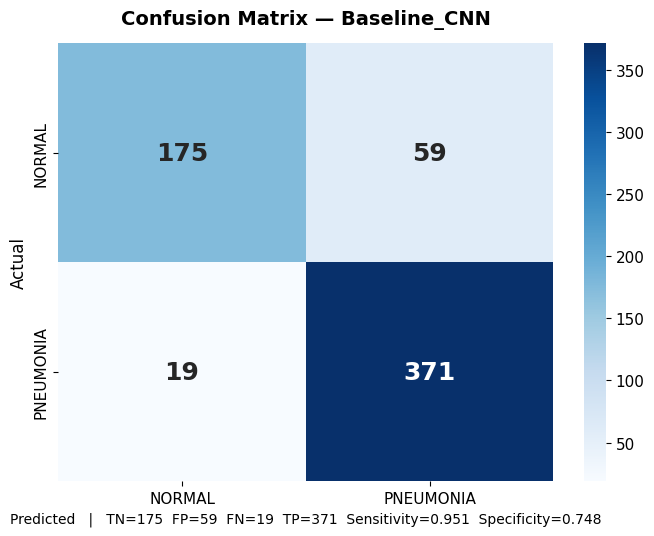

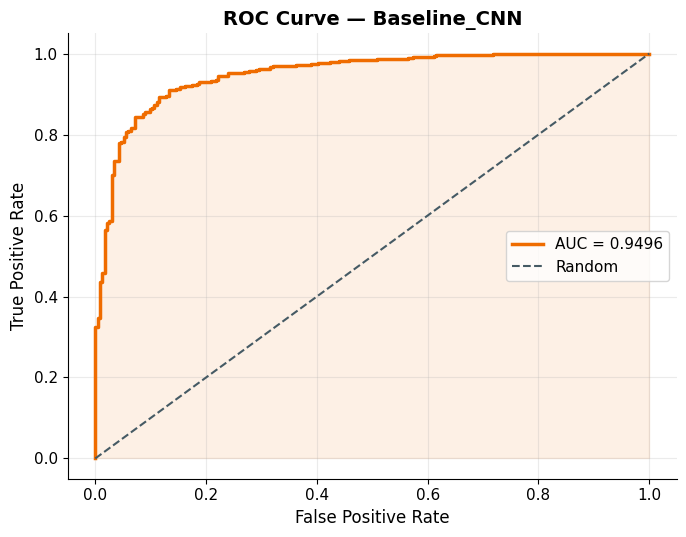

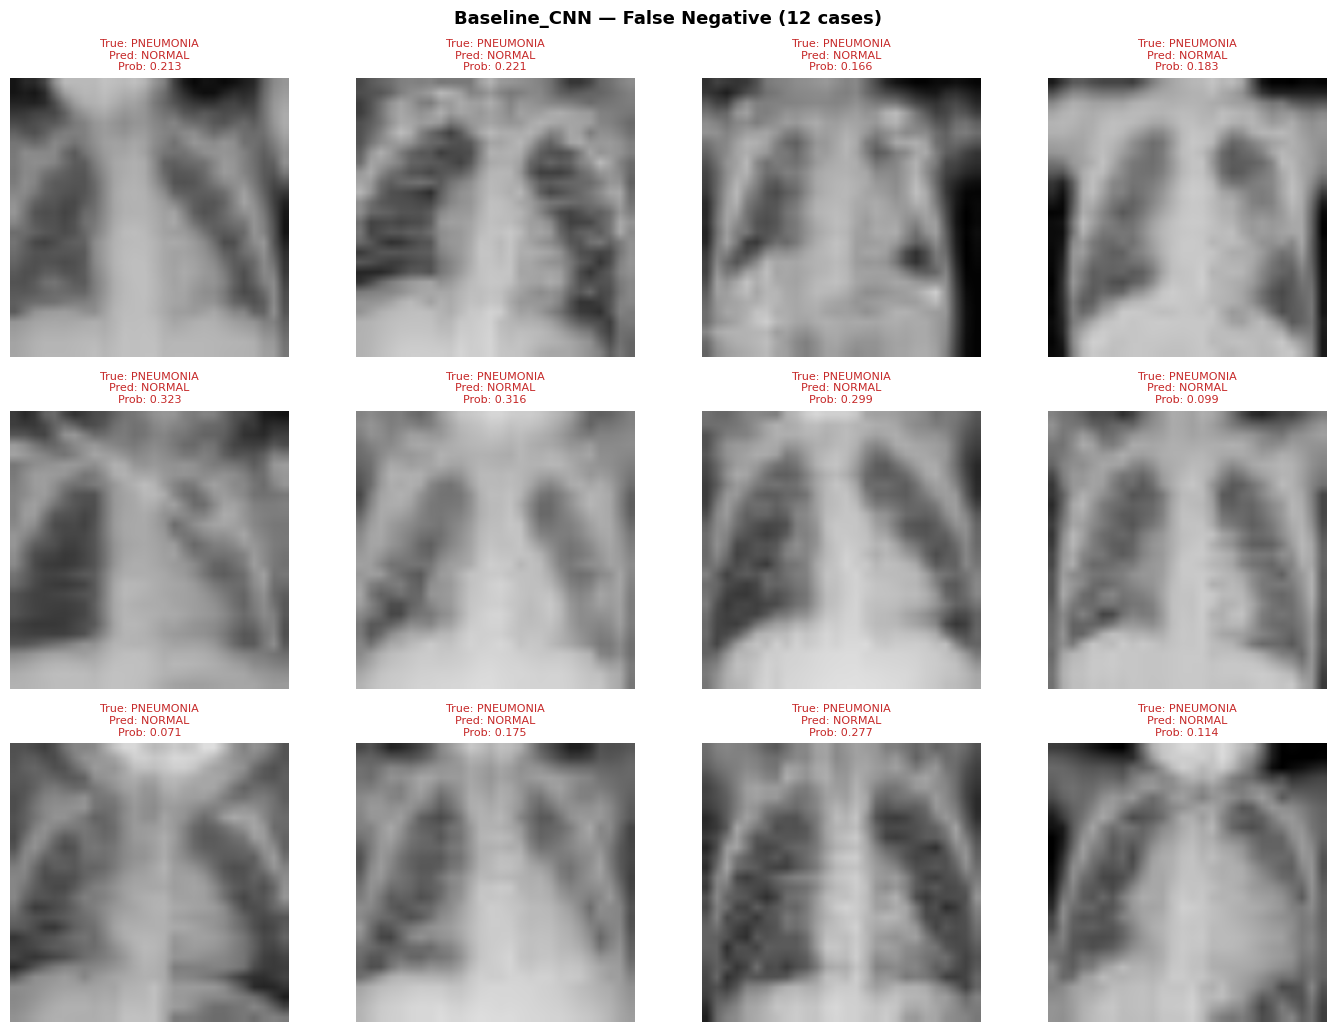

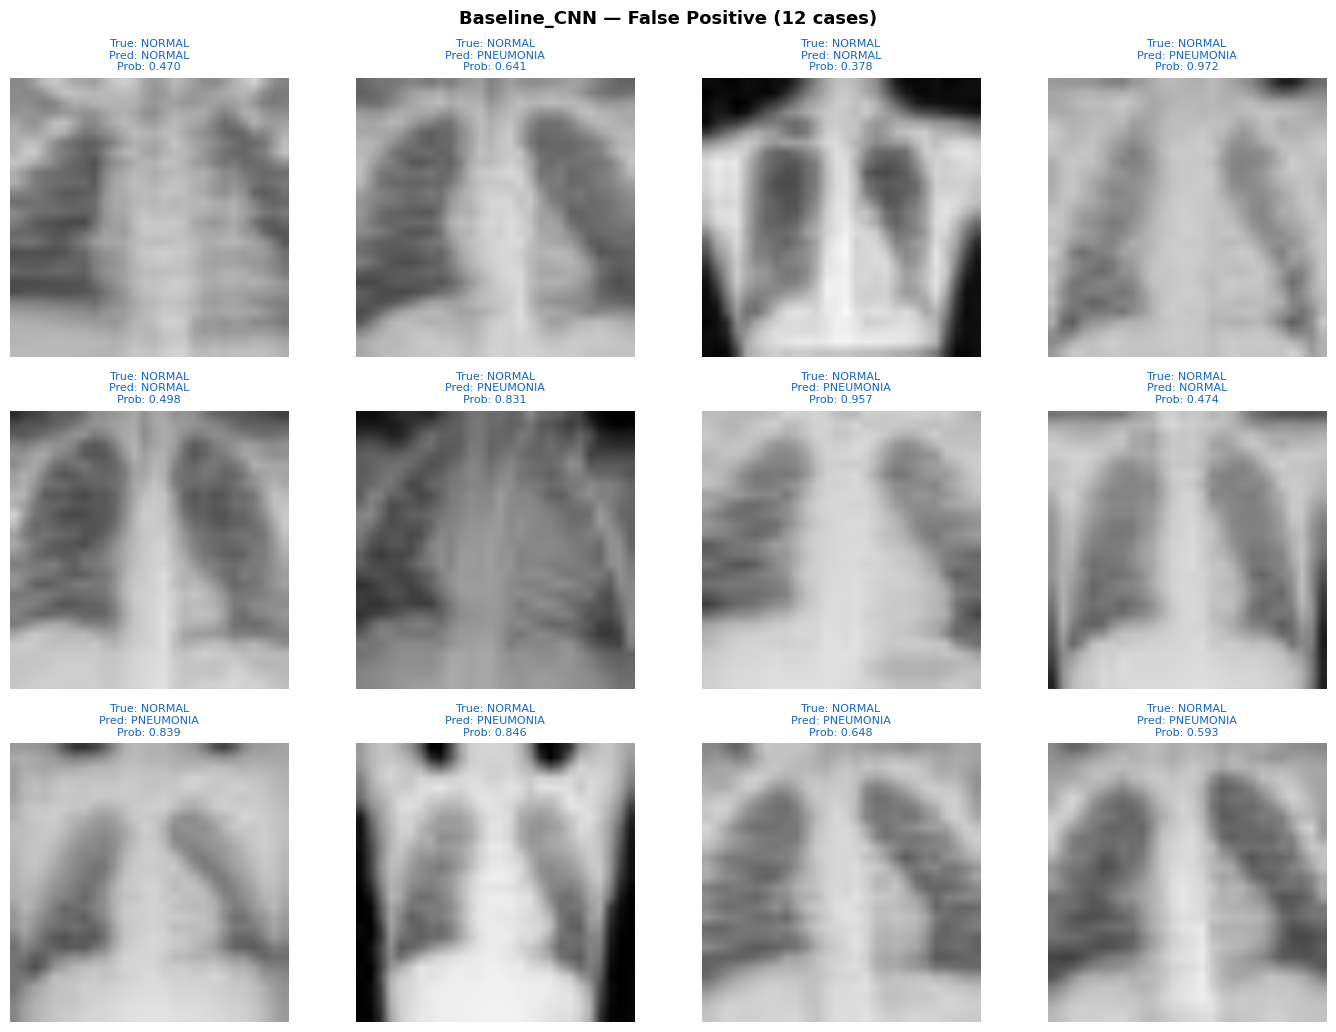

In [13]:
results_dict = {}

if TRAIN_BASELINE:
    bl_metrics, bl_true, bl_probs = evaluate_model(
        baseline_model, 'Baseline_CNN', val_ds, test_ds)
    results_dict['Baseline CNN'] = bl_metrics
else:
    print("Baseline not trained — set TRAIN_BASELINE=True.")

## 📋  Evaluate ResNet50


  Evaluating: ResNet50_Advanced
  Optimal threshold (val F1=0.9553): 0.30

  Test Metrics:
    Accuracy    : 0.8878
    Precision   : 0.8687
    Recall      : 0.9667
    F1-Score    : 0.9150
    ROC-AUC     : 0.9561
    Threshold   : 0.3000

  Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.76      0.83       234
   PNEUMONIA       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624



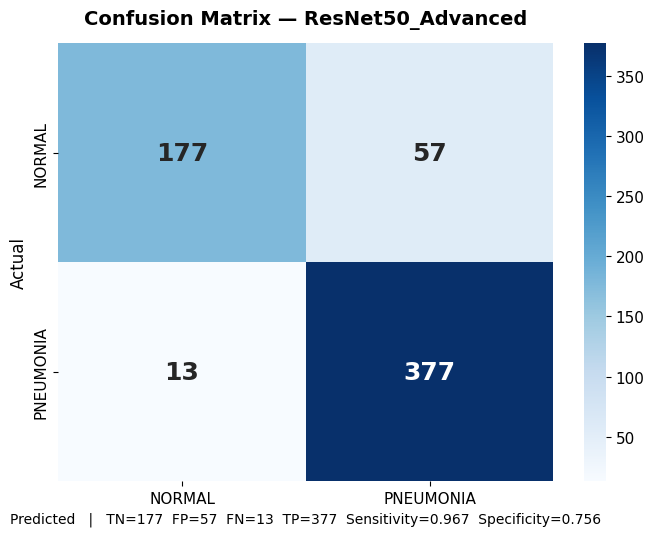

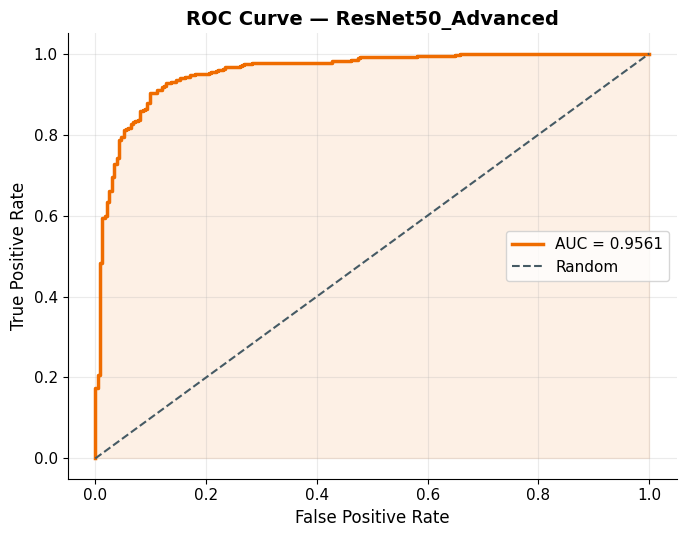

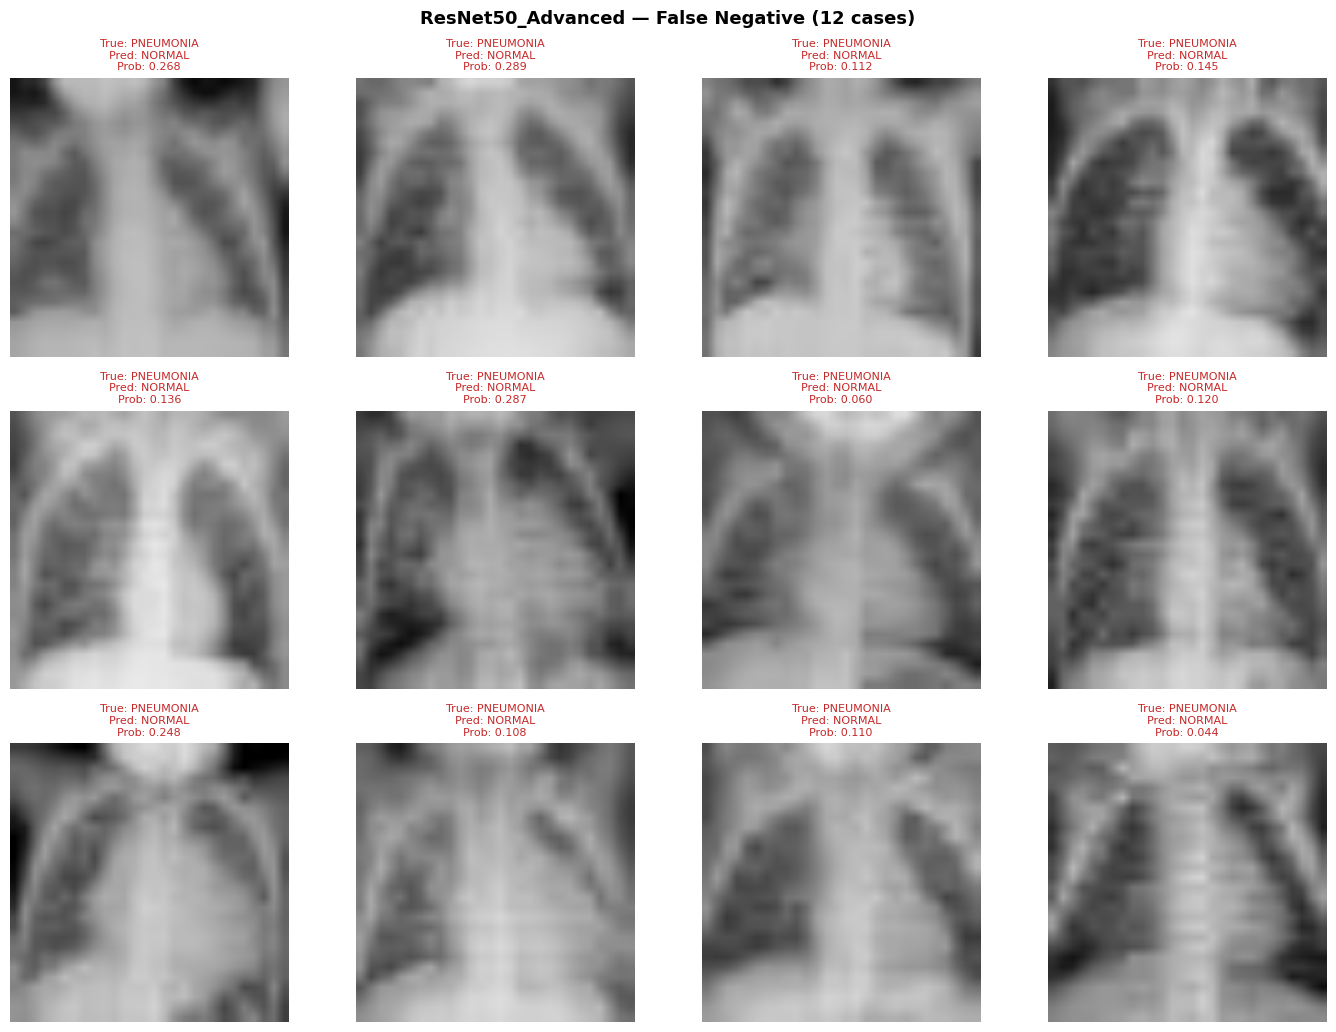

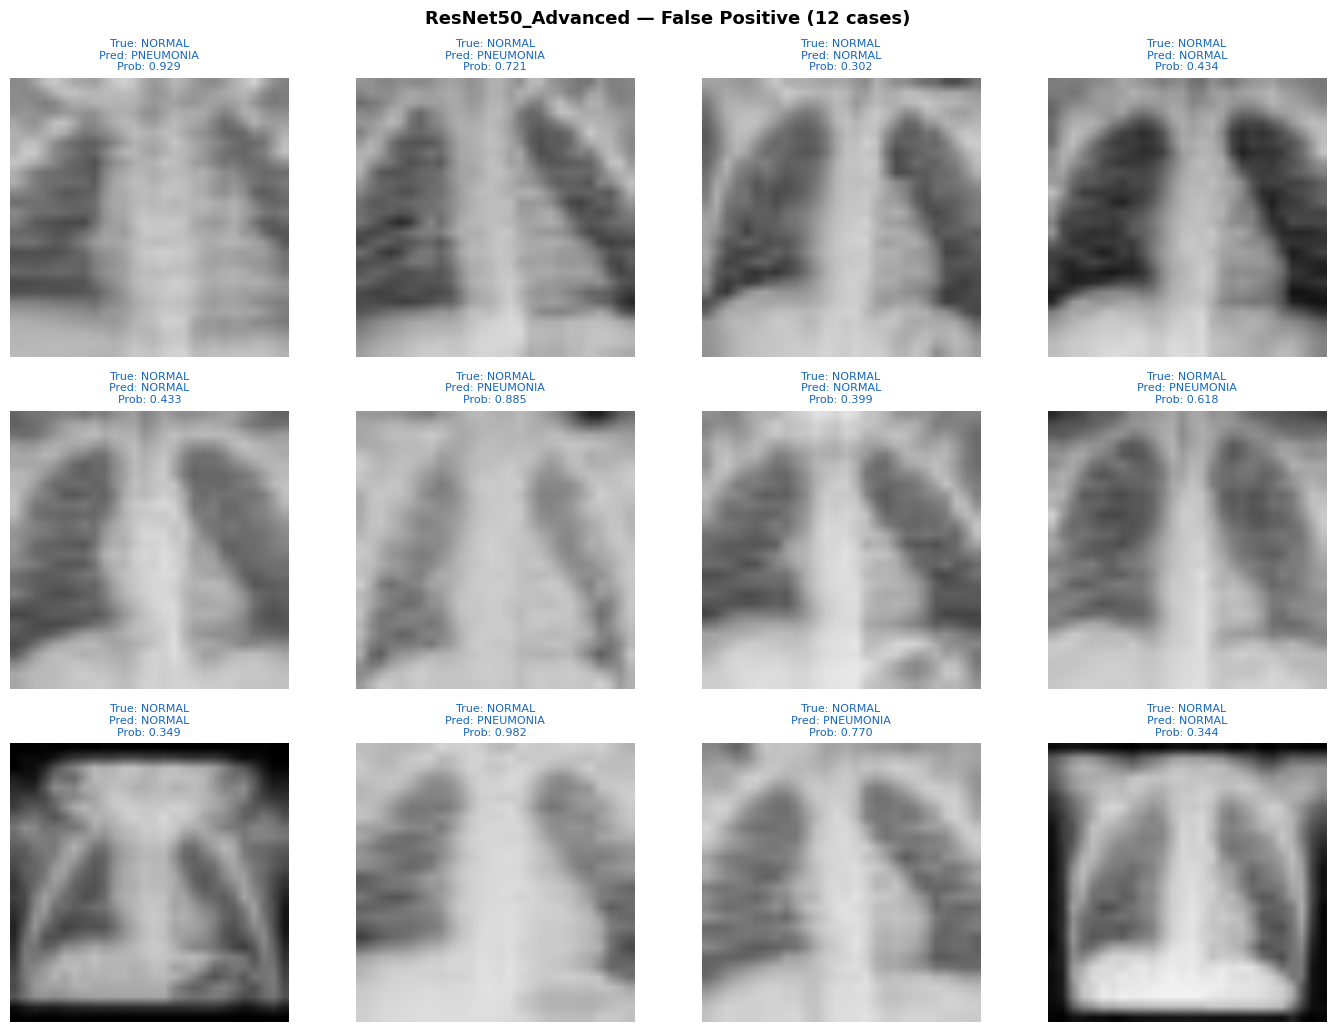

In [17]:
if TRAIN_ADVANCED:
    rn_metrics, rn_true, rn_probs = evaluate_model(
        resnet_model, 'ResNet50_Advanced', val_ds, test_ds)
    results_dict['ResNet50 Advanced'] = rn_metrics
else:
    print("ResNet50 not trained — set TRAIN_ADVANCED=True.")

## 📊  Full Model Comparison
> **5 comparison views**: Metrics table • Bar chart (★ winner) • Side-by-side ROC • Side-by-side Confusion Matrices • Training History (AUC + Loss) • Radar chart


  MODEL PERFORMANCE COMPARISON (Test Set)
              Accuracy  Precision  Recall  F1-Score  ROC-AUC
Baseline CNN    0.8750     0.8628  0.9513    0.9049   0.9496

  Winner per metric:
    Accuracy     → Baseline CNN (0.8750)
    Precision    → Baseline CNN (0.8628)
    Recall       → Baseline CNN (0.9513)
    F1-Score     → Baseline CNN (0.9049)
    ROC-AUC      → Baseline CNN (0.9496)


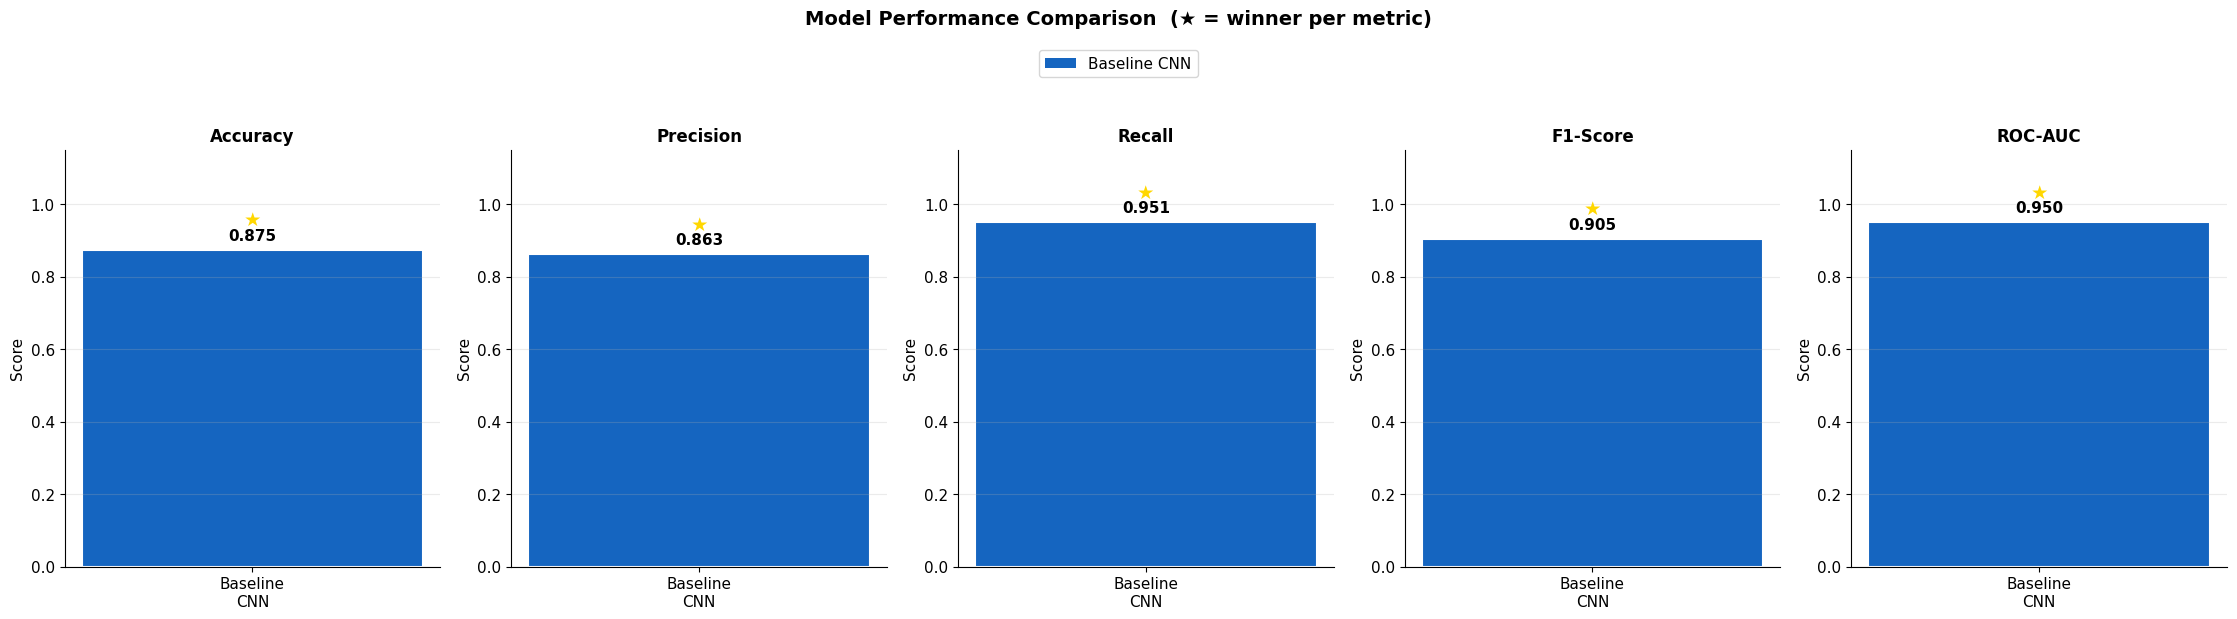

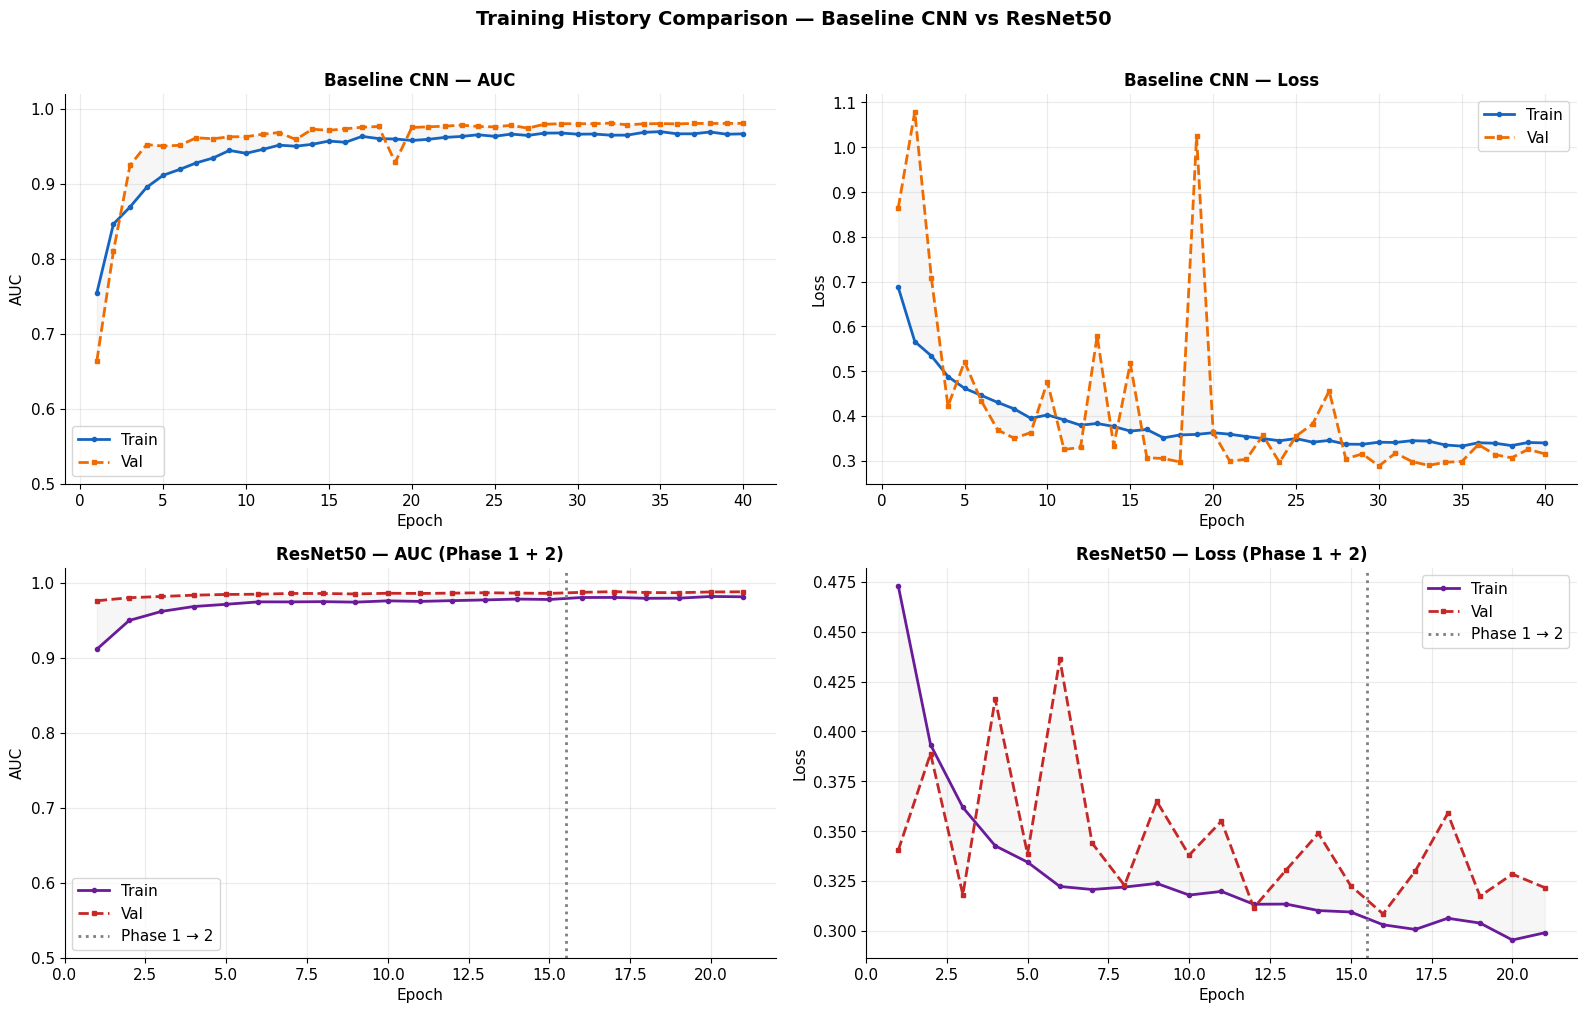

💾 Saved comparison_history.png


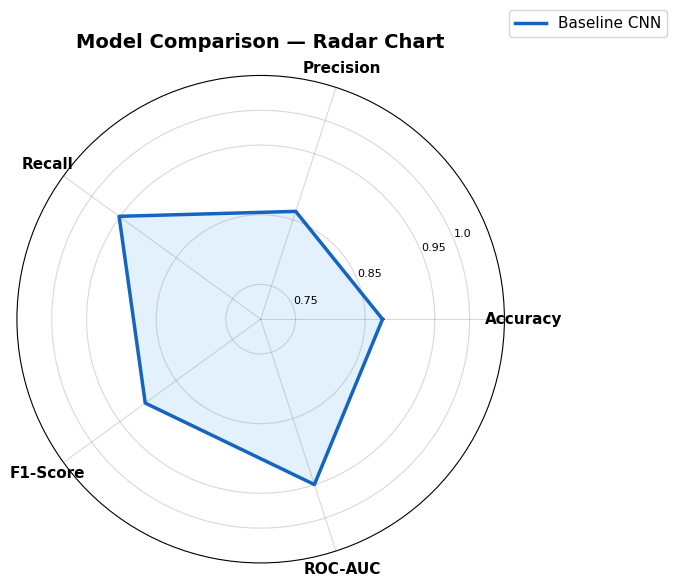

💾 All comparison plots saved.


In [14]:
# ═══════════════════════════════════════════════════════════
#  COMPREHENSIVE MODEL COMPARISON
#  Baseline CNN  vs  ResNet50 Advanced
# ═══════════════════════════════════════════════════════════

if len(results_dict) == 0:
    print('No results yet — run evaluation cells first.')
else:
    display_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    df = pd.DataFrame(results_dict).T[display_cols]

    # ── 1. Metrics Table ────────────────────────────────────────
    print('\n' + '='*58)
    print('  MODEL PERFORMANCE COMPARISON (Test Set)')
    print('='*58)
    print(df.to_string(float_format='{:.4f}'.format))

    # winner per metric
    print('\n  Winner per metric:')
    for col in display_cols:
        winner = df[col].idxmax()
        val    = df[col].max()
        print(f'    {col:12s} → {winner} ({val:.4f})')

    # ── 2. Bar chart comparison ──────────────────────────────────
    colors = ['#1565C0', '#EF6C00']
    fig, axes = plt.subplots(1, len(display_cols),
                             figsize=(4.5 * len(display_cols), 5.5))

    for ax, col in zip(axes, display_cols):
        vals  = df[col].values
        names = [n.replace(' ', '\n') for n in df.index.tolist()]
        bars  = ax.bar(names, vals, color=colors[:len(vals)],
                       width=0.5, edgecolor='white', linewidth=1.5)
        ax.set_ylim(0, 1.15)
        ax.set_title(col, fontsize=12, fontweight='bold')
        ax.set_ylabel('Score')
        ax.grid(axis='y', alpha=0.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for bar, v in zip(bars, vals):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.018,
                    f'{v:.3f}', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')
        # star on winner
        best_i = int(np.argmax(vals))
        axes_bars = bars
        ax.text(bars[best_i].get_x() + bars[best_i].get_width()/2,
                bars[best_i].get_height() + 0.055,
                '★', ha='center', va='bottom',
                fontsize=14, color='gold')

    # legend
    from matplotlib.patches import Patch
    legend_els = [Patch(facecolor=colors[i], label=df.index[i])
                  for i in range(len(df))]
    fig.legend(handles=legend_els, loc='upper center',
               ncol=len(df), fontsize=11,
               bbox_to_anchor=(0.5, 1.06))
    fig.suptitle('Model Performance Comparison  (★ = winner per metric)',
                 fontsize=14, fontweight='bold', y=1.12)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, 'comparison_bar.png'),
                dpi=150, bbox_inches='tight')
    plt.show()

    # ── 3. Side-by-side ROC curves ──────────────────────────────
    if 'bl_true' in dir() and 'rn_true' in dir():
        fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
        datasets = [
            (bl_true, bl_probs, 'Baseline CNN',     '#1565C0'),
            (rn_true, rn_probs, 'ResNet50 Advanced', '#EF6C00'),
        ]
        for ax, (yt, yp, name, col) in zip(axes, datasets):
            fpr, tpr, _ = roc_curve(yt, yp)
            ra = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=col, lw=2.5,
                    label=f'AUC = {ra:.4f}')
            ax.plot([0,1],[0,1], color='#90A4AE',
                    lw=1.5, linestyle='--', label='Random')
            ax.fill_between(fpr, tpr, alpha=0.10, color=col)
            ax.set_title(f'ROC — {name}',
                         fontsize=13, fontweight='bold')
            ax.set_xlabel('False Positive Rate', fontsize=11)
            ax.set_ylabel('True Positive Rate',  fontsize=11)
            ax.legend(fontsize=11)
            ax.grid(True, alpha=0.25)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        fig.suptitle('ROC Curve Comparison', fontsize=14,
                     fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(os.path.join(Config.OUTPUT_DIR, 'comparison_roc.png'),
                    dpi=150, bbox_inches='tight')
        plt.show()

    # ── 4. Side-by-side Confusion Matrices ──────────────────────
    if 'bl_true' in dir() and 'rn_true' in dir():
        thr_bl = results_dict.get('Baseline CNN',    {}).get('Threshold', 0.5)
        thr_rn = results_dict.get('ResNet50 Advanced',{}).get('Threshold', 0.5)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
        combos = [
            (bl_true, bl_probs, thr_bl, 'Baseline CNN',     'Blues'),
            (rn_true, rn_probs, thr_rn, 'ResNet50 Advanced', 'Oranges'),
        ]
        for ax, (yt, yp, thr, name, cmap) in zip(axes, combos):
            ypred = (yp > thr).astype(int)
            cm    = confusion_matrix(yt, ypred)
            sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                        xticklabels=Config.CLASS_NAMES,
                        yticklabels=Config.CLASS_NAMES,
                        annot_kws={'size': 18, 'weight': 'bold'},
                        linewidths=1, linecolor='white')
            tn, fp, fn, tp = cm.ravel()
            ax.set_title(
                f'{name}\n'
                f'Sensitivity: {tp/(tp+fn):.3f}   '
                f'Specificity: {tn/(tn+fp):.3f}   '
                f'Threshold: {thr:.2f}',
                fontsize=11, fontweight='bold')
            ax.set_xlabel('Predicted', fontsize=11)
            ax.set_ylabel('Actual',    fontsize=11)

        fig.suptitle('Confusion Matrix Comparison', fontsize=14,
                     fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(os.path.join(Config.OUTPUT_DIR, 'comparison_cm.png'),
                    dpi=150, bbox_inches='tight')
        plt.show()

    # ── 5. Side-by-side Training History (AUC) ──────────────────
    histories_available = []
    if 'baseline_history' in dir():
        histories_available.append(
            (baseline_history, 'Baseline CNN', '#1565C0', '#EF6C00'))
    if 'phase1_history' in dir() and 'phase2_history' in dir():
        # Combine phase1 + phase2 AUC for full picture
        p1h = phase1_history.history
        p2h = phase2_history.history
        combined_tr_auc  = p1h.get('auc', []) + p2h.get('auc', [])
        combined_val_auc = p1h.get('val_auc', []) + p2h.get('val_auc', [])
        combined_tr_loss  = p1h.get('loss', []) + p2h.get('loss', [])
        combined_val_loss = p1h.get('val_loss', []) + p2h.get('val_loss', [])
        histories_available.append(
            (None, 'ResNet50 Advanced', '#6A1B9A', '#C62828',
             combined_tr_auc, combined_val_auc,
             combined_tr_loss, combined_val_loss,
             len(p1h.get('auc', []))))

    if len(histories_available) == 2:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # Baseline rows
        bh  = baseline_history.history
        ep1 = range(1, len(bh['auc']) + 1)
        # AUC
        axes[0,0].plot(ep1, bh['auc'],     color='#1565C0', lw=2, label='Train', marker='o', ms=3)
        axes[0,0].plot(ep1, bh['val_auc'], color='#EF6C00', lw=2, label='Val',   marker='s', ms=3, ls='--')
        axes[0,0].fill_between(ep1, bh['auc'], bh['val_auc'], alpha=0.07, color='grey')
        axes[0,0].set_title('Baseline CNN — AUC', fontsize=12, fontweight='bold')
        axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('AUC')
        axes[0,0].legend(); axes[0,0].grid(True, alpha=0.25)
        axes[0,0].set_ylim(0.5, 1.02)
        # Loss
        axes[0,1].plot(ep1, bh['loss'],     color='#1565C0', lw=2, label='Train', marker='o', ms=3)
        axes[0,1].plot(ep1, bh['val_loss'], color='#EF6C00', lw=2, label='Val',   marker='s', ms=3, ls='--')
        axes[0,1].fill_between(ep1, bh['loss'], bh['val_loss'], alpha=0.07, color='grey')
        axes[0,1].set_title('Baseline CNN — Loss', fontsize=12, fontweight='bold')
        axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
        axes[0,1].legend(); axes[0,1].grid(True, alpha=0.25)

        # ResNet50 rows (combined)
        _, _, tc, vc, tr_auc, vl_auc, tr_loss, vl_loss, phase1_len = histories_available[1]
        ep2 = range(1, len(tr_auc) + 1)
        # AUC
        axes[1,0].plot(ep2, tr_auc, color='#6A1B9A', lw=2, label='Train', marker='o', ms=3)
        axes[1,0].plot(ep2, vl_auc, color='#C62828', lw=2, label='Val',   marker='s', ms=3, ls='--')
        axes[1,0].fill_between(ep2, tr_auc, vl_auc, alpha=0.07, color='grey')
        if phase1_len > 0:
            axes[1,0].axvline(x=phase1_len + 0.5, color='grey',
                              ls=':', lw=2, label='Phase 1 → 2')
        axes[1,0].set_title('ResNet50 — AUC (Phase 1 + 2)', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Epoch'); axes[1,0].set_ylabel('AUC')
        axes[1,0].legend(); axes[1,0].grid(True, alpha=0.25)
        axes[1,0].set_ylim(0.5, 1.02)
        # Loss
        axes[1,1].plot(ep2, tr_loss, color='#6A1B9A', lw=2, label='Train', marker='o', ms=3)
        axes[1,1].plot(ep2, vl_loss, color='#C62828', lw=2, label='Val',   marker='s', ms=3, ls='--')
        axes[1,1].fill_between(ep2, tr_loss, vl_loss, alpha=0.07, color='grey')
        if phase1_len > 0:
            axes[1,1].axvline(x=phase1_len + 0.5, color='grey',
                              ls=':', lw=2, label='Phase 1 → 2')
        axes[1,1].set_title('ResNet50 — Loss (Phase 1 + 2)', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Epoch'); axes[1,1].set_ylabel('Loss')
        axes[1,1].legend(); axes[1,1].grid(True, alpha=0.25)

        for ax in axes.flatten():
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        fig.suptitle('Training History Comparison — Baseline CNN vs ResNet50',
                     fontsize=14, fontweight='bold', y=1.01)
        plt.tight_layout()
        plt.savefig(os.path.join(Config.OUTPUT_DIR, 'comparison_history.png'),
                    dpi=150, bbox_inches='tight')
        plt.show()
        print('💾 Saved comparison_history.png')

    # ── 6. Radar / Spider chart ──────────────────────────────────
    from matplotlib.patches import FancyArrowPatch
    import matplotlib.patheffects as pe

    metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    N = len(metrics_radar)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]   # close the loop

    fig, ax = plt.subplots(figsize=(7, 7),
                           subplot_kw=dict(polar=True))
    palette = [('#1565C0', '#90CAF9'), ('#EF6C00', '#FFCC80')]

    for (name, row), (solid, light) in zip(df.iterrows(), palette):
        vals = row[metrics_radar].values.tolist()
        vals += vals[:1]
        ax.plot(angles, vals, color=solid, lw=2.5, label=name)
        ax.fill(angles, vals, color=light, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_radar, fontsize=11, fontweight='bold')
    ax.set_ylim(0.7, 1.05)
    ax.set_yticks([0.75, 0.85, 0.95, 1.0])
    ax.set_yticklabels(['0.75', '0.85', '0.95', '1.0'], fontsize=8)
    ax.grid(color='grey', alpha=0.3)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15), fontsize=11)
    ax.set_title('Model Comparison — Radar Chart',
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, 'comparison_radar.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    print('💾 All comparison plots saved.')


## 🔮  Interactive Prediction Demo

Demo: 4 random test samples



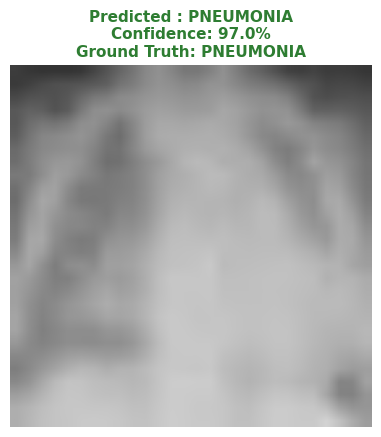

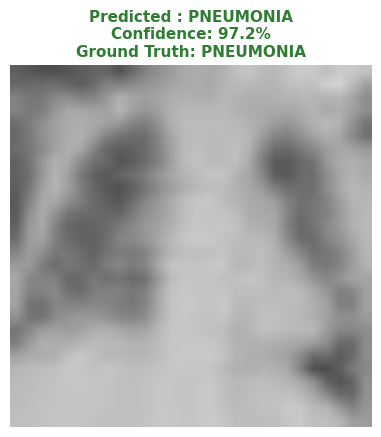

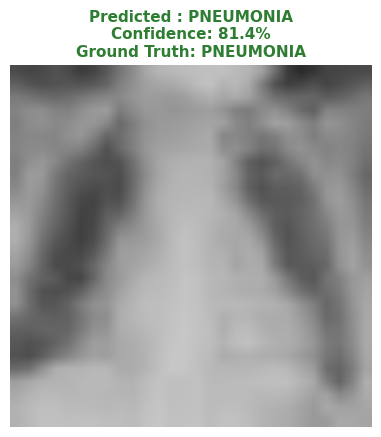

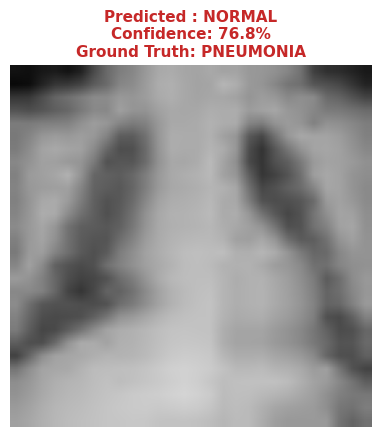

In [15]:
def predict_single(model, image, true_label=None, threshold=0.5):
    """Run inference on one image and display result inline."""
    prob      = float(model.predict(image[np.newaxis], verbose=0)[0][0])
    pred_cls  = int(prob > threshold)
    confidence = prob if pred_cls == 1 else 1 - prob
    correct   = (true_label is None) or (pred_cls == int(true_label))

    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.imshow(np.clip(image, 0, 1), cmap='gray')

    title  = f"Predicted : {Config.CLASS_NAMES[pred_cls]}\n"
    title += f"Confidence: {confidence:.1%}\n"
    if true_label is not None:
        title += f"Ground Truth: {Config.CLASS_NAMES[int(true_label)]}"

    ax.set_title(title, fontsize=11, fontweight='bold',
                 color='#2E7D32' if correct else '#C62828')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    return pred_cls, prob


# Pick the best available model
demo_model = resnet_model if (TRAIN_ADVANCED and 'resnet_model' in dir()) \
             else (baseline_model if TRAIN_BASELINE else None)

if demo_model is not None:
    print("Demo: 4 random test samples\n")
    for imgs, labs in test_ds.take(1):
        idxs = np.random.choice(len(imgs), 4, replace=False)
        for i in idxs:
            predict_single(demo_model, imgs[i].numpy(), labs[i].numpy())
        break
else:
    print("No trained model available.")

## 💾 Save / Load Models (Optional)

In [16]:
# ── Save ──────────────────────────────────────────────────────────
SAVE_MODELS = True

if SAVE_MODELS:
    if TRAIN_BASELINE and 'baseline_model' in dir():
        p = os.path.join(Config.OUTPUT_DIR, 'baseline_cnn_final.keras')
        baseline_model.save(p)
        print(f"✅ Baseline CNN saved → {p}")

    if TRAIN_ADVANCED and 'resnet_model' in dir():
        p = os.path.join(Config.OUTPUT_DIR, 'resnet50_final.keras')
        resnet_model.save(p)
        print(f"✅ ResNet50 saved     → {p}")

# ── Load ──────────────────────────────────────────────────────────
LOAD_MODELS = False   # Set True to reload saved models

if LOAD_MODELS:
    bl_path = os.path.join(Config.OUTPUT_DIR, 'baseline_cnn_final.keras')
    rn_path = os.path.join(Config.OUTPUT_DIR, 'resnet50_final.keras')

    if os.path.exists(bl_path):
        baseline_model = tf.keras.models.load_model(bl_path)
        print(f"Loaded: {bl_path}")
    if os.path.exists(rn_path):
        resnet_model = tf.keras.models.load_model(rn_path)
        print(f"Loaded: {rn_path}")

✅ Baseline CNN saved → outputs/baseline_cnn_final.keras
✅ ResNet50 saved     → outputs/resnet50_final.keras
